In [ ]:
done = False

# Homework 5
### ASTR-324, University of Washington


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall the MCMC lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then visually compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models. **There's no need to do quantitative model-comparison**.
- Use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can solve this problem by generalizing the code from class.

The data:

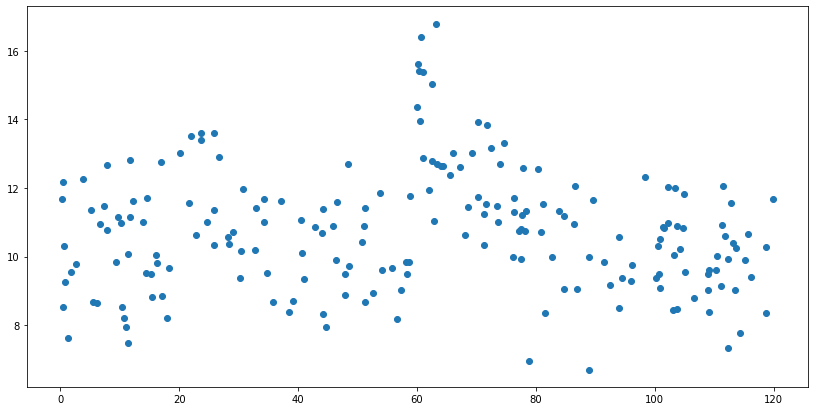

In [2]:
plt.figure(figsize=(14,7))
plt.scatter(t,y_obs);



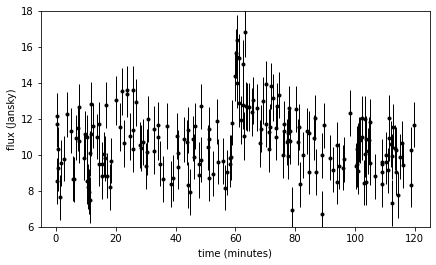

In [36]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# read data
data = np.loadtxt('data/burst.dataset.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

# Solution

## Initial Setup

In [58]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import plot_mcmc
import pymc3 as pm

In [59]:
# A utility function to convert the traces (chains) to a Pandas DataFrame
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

In [60]:
def sample_model(two_bursts):
    if two_bursts == False:
        def burst1(t, b0, A, alpha, T):
            """Burst model"""
            mask = (t >= T)
            y = b0 + mask * A * np.exp(-alpha * (t - T))
            return y
        
        with pm.Model():
            b0 = pm.Uniform('b0', 0, 50)
            A = pm.Uniform('A', 0, 50)
            T = pm.Uniform('T', 0, 100)
            log_alpha = pm.Uniform('log_alpha', -10, 10)

            y = pm.Normal('y', mu=burst1(t, b0, A, np.exp(log_alpha), T), sd=sigma_y, observed=y_obs)

            step = pm.Metropolis()
            traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
        
    else:
        def burst2(t, b0, A1, alpha1, T1, A2, alpha2, T2):
            """Burst model"""
            mask1 = (t >= T1)
            mask2 = (t >= T2)
            y = b0 + mask1 * A1 * np.exp(-alpha1 * (t - T1)) + mask2 * A2 * np.exp(-alpha2 * (t-T2))
            return y
        
        with pm.Model():
            b0 = pm.Uniform('b0', 0, 50)
            A1 = pm.Uniform('A1', 0, 50)
            T1 = pm.Uniform('T1', 0, 100)
            log_alpha1 = pm.Uniform('log_alpha1', -10, 10)
            A2 = pm.Uniform('A2', 0, 50)
            T2 = pm.Uniform('T2', 0, 100)
            log_alpha2 = pm.Uniform('log_alpha2', -10, 10)

            y = pm.Normal('y', mu=burst2(t, b0, A1, np.exp(log_alpha1),T1, A2, np.exp(log_alpha2), T2), sd=sigma_y, observed=y_obs)

            step = pm.Metropolis()
            traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
    return traces
       

In [61]:
def plot_traces(traces, two_bursts):

    if two_bursts == False:
        df = traces_to_pandas(traces, 1000)
        df["alpha"] = np.exp(traces['log_alpha'])
        del df["log_alpha"]

        variables = ['b0', 'A', 'T', 'alpha' ]
        labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
        limits = [(9.2, 11.2), (2, 12), (55, 65), (0.0, 0.25)] 
        #true = [b0_true, A_true, T_true, alpha_true]

        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(bottom=0.1, top=0.95,
                            left=0.1, right=0.95,
                            hspace=0.05, wspace=0.05)

        # This function plots multiple panels with the traces
        plot_mcmc([df[col] for col in variables],
                  labels=labels, limits=limits,
                  fig=fig, bins=30, colors='k')
                  #true_values=true, fig=fig, bins=30, colors='k')

        # Plot the model fit
        ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
        t_fit = np.linspace(0, 100, 1000)
        y_fit = burst1(t_fit, **df.median())
        #y_true = burst1(t_fit, b0_true, A_true, alpha_true, T_true)

        ax.scatter(t, y_obs, s=9, lw=0, c='k')
        #ax.plot(t_fit, y_true, '--', c='blue', label="true")
        ax.plot(t_fit, y_fit, '-r', label="fit")
        ax.legend()
        ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
        ax.set_xlim(0, 100)
        ax.set_xlabel('$t$')
        ax.set_ylabel(r'$h_{\rm obs}$')

        plt.show()
        
    else:
        df = traces_to_pandas(traces, 1000)
        df["alpha1"] = np.exp(traces['log_alpha1'])
        df["alpha2"] = np.exp(traces['log_alpha2'])
        del df["log_alpha1"]
        del df["log_alpha2"]

        variables = ['b0', 'A1', 'T1', 'alpha1', 'A2', 'T2', 'alpha2']
        labels = ['$b_0$', '$A1$', '$T1$', r'$\alpha1$','$A2$', '$T2$', r'$\alpha2$']
        limits = [(9.2, 11.2), (0, 10), (15, 25), (0.001, 0.45),(0, 8), (55, 65), (0.001, 0.25)]
        #true = [b0_true, A_true, T_true, alpha_true]

        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(bottom=0.1, top=0.95,
                            left=0.1, right=0.95,
                            hspace=0.05, wspace=0.05)

        # This function plots multiple panels with the traces
        plot_mcmc([df[col] for col in variables],
                  labels=labels, limits=limits,
                  fig=fig, bins=30, colors='k')
                  #true_values=true, fig=fig, bins=30, colors='k')

        # Plot the model fit
        ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
        t_fit = np.linspace(0, 100, 1000)
        y_fit = burst2(t_fit, **df.median())
        #y_true = burst2(t_fit, b0_true, A_true, alpha_true, T_true)

        ax.scatter(t, y_obs, s=9, lw=0, c='k')
        #ax.plot(t_fit, y_true, '--', c='blue', label="true")
        ax.plot(t_fit, y_fit, '-r', label="fit")
        ax.legend()
        ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
        ax.set_xlim(0, 100)
        ax.set_xlabel('$t$')
        ax.set_ylabel(r'$h_{\rm obs}$')

        plt.show()


## One Burst

/tmp/ipykernel_98/1466402145.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 13 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (25000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


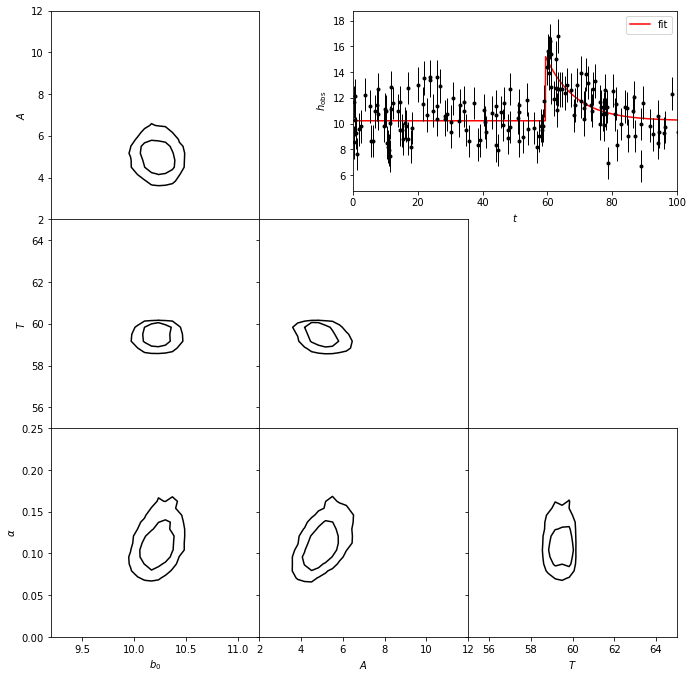

In [62]:
traces = sample_model(two_bursts=False)
plot_traces(traces, two_bursts=False)

## Two bursts

/tmp/ipykernel_98/1466402145.py:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha2]
>Metropolis: [T2]
>Metropolis: [A2]
>Metropolis: [log_alpha1]
>Metropolis: [T1]
>Metropolis: [A1]
>Metropolis: [b0]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 27 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (25000) than draws (7). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


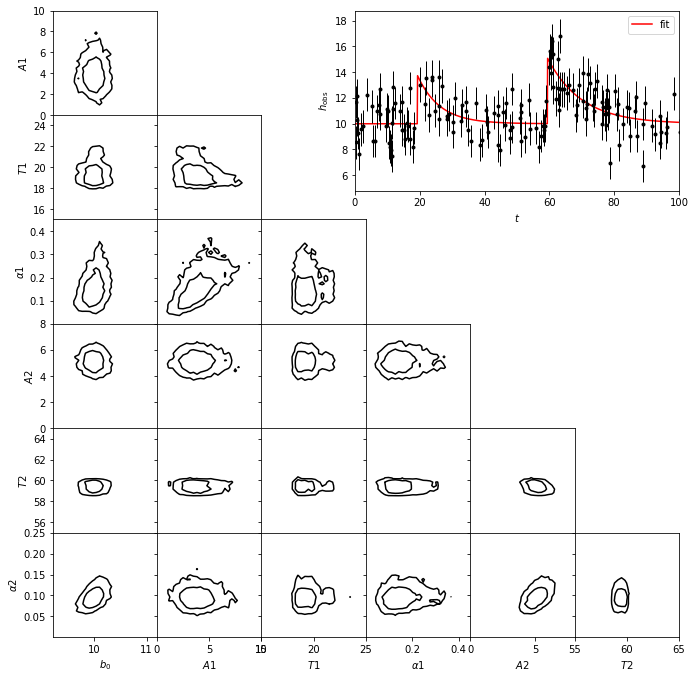

In [63]:
traces = sample_model(two_bursts=True)
plot_traces(traces, two_bursts=True)

# Scratch Work

In [40]:
def burst1(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

In [41]:
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50)
    A = pm.Uniform('A', 0, 50)
    T = pm.Uniform('T', 0, 100)
    log_alpha = pm.Uniform('log_alpha', -10, 10)

    y = pm.Normal('y', mu=burst1(t, b0, A, np.exp(log_alpha), T), sd=sigma_y, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)

/tmp/ipykernel_98/2012582158.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 13 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (25000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


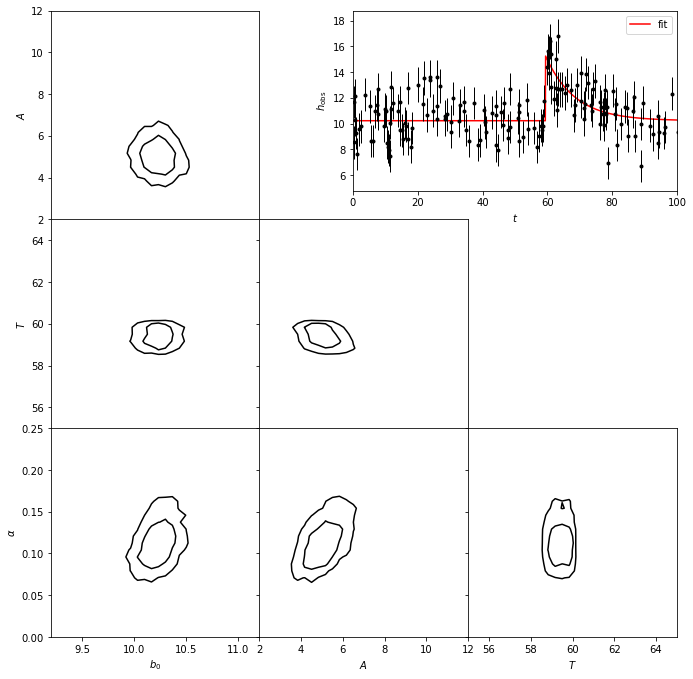

In [42]:
df = traces_to_pandas(traces, 1000)
df["alpha"] = np.exp(traces['log_alpha'])
del df["log_alpha"]

variables = ['b0', 'A', 'T', 'alpha' ]
labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.2, 11.2), (2, 12), (55, 65), (0.0, 0.25)] 
#true = [b0_true, A_true, T_true, alpha_true]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          fig=fig, bins=30, colors='k')
          #true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = burst1(t_fit, **df.median())
#y_true = burst1(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
#ax.plot(t_fit, y_true, '--', c='blue', label="true")
ax.plot(t_fit, y_fit, '-r', label="fit")
ax.legend()
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

## One burst

In [8]:
traces = sample_model(two_bursts=False)
plot_traces(traces, figsize=(7, 7))

NameError: name 'sample_model' is not defined

/tmp/ipykernel_98/1466402145.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha]
>Metropolis: [T]
>Metropolis: [A]
>Metropolis: [b0]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 14 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (25000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


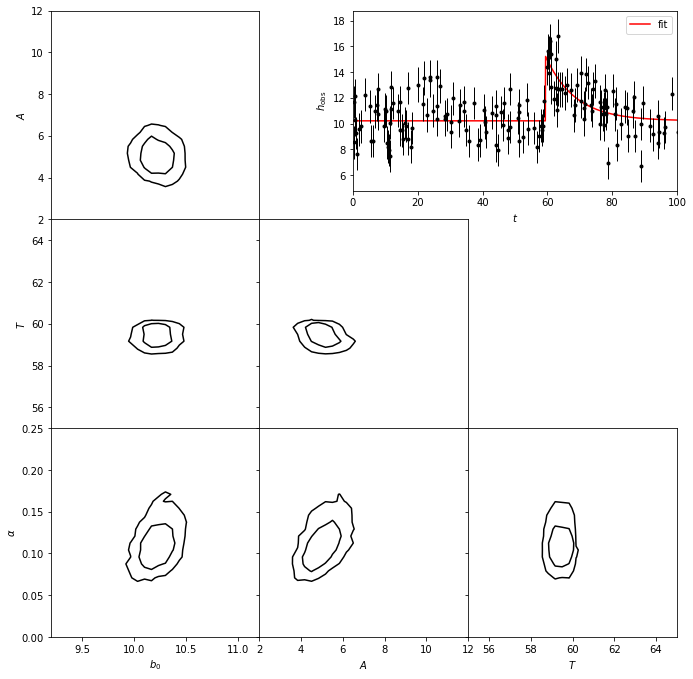

In [57]:
traces = sample_model(two_bursts=False)
plot_traces(traces, two_bursts=False)

## Two bursts

In [43]:
def burst2(t, b0, A1, alpha1, T1, A2, alpha2, T2):
    """Burst model"""
    mask1 = (t >= T1)
    mask2 = (t >= T2)
    y = b0 + mask1 * A1 * np.exp(-alpha1 * (t - T1)) + mask2 * A2 * np.exp(-alpha2 * (t-T2))
    return y

In [44]:
with pm.Model():
    b0 = pm.Uniform('b0', 0, 50)
    A1 = pm.Uniform('A1', 0, 50)
    T1 = pm.Uniform('T1', 0, 100)
    log_alpha1 = pm.Uniform('log_alpha1', -10, 10)
    A2 = pm.Uniform('A2', 0, 50)
    T2 = pm.Uniform('T2', 0, 100)
    log_alpha2 = pm.Uniform('log_alpha2', -10, 10)

    y = pm.Normal('y', mu=burst2(t, b0, A1, np.exp(log_alpha1),T1, A2, np.exp(log_alpha2), T2), sd=sigma_y, observed=y_obs)

    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)

/tmp/ipykernel_98/1721186627.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha2]
>Metropolis: [T2]
>Metropolis: [A2]
>Metropolis: [log_alpha1]
>Metropolis: [T1]
>Metropolis: [A1]
>Metropolis: [b0]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 28 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (25000) than draws (7). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


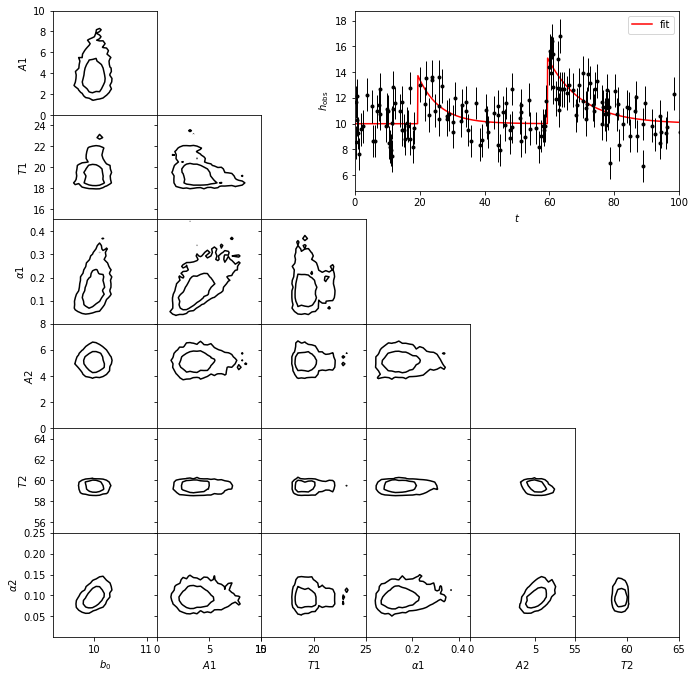

In [48]:
df = traces_to_pandas(traces, 1000)
df["alpha1"] = np.exp(traces['log_alpha1'])
df["alpha2"] = np.exp(traces['log_alpha2'])
del df["log_alpha1"]
del df["log_alpha2"]

variables = ['b0', 'A1', 'T1', 'alpha1', 'A2', 'T2', 'alpha2']
labels = ['$b_0$', '$A1$', '$T1$', r'$\alpha1$','$A2$', '$T2$', r'$\alpha2$']
limits = [(9.2, 11.2), (0, 10), (15, 25), (0.001, 0.45),(0, 8), (55, 65), (0.001, 0.25)]
#true = [b0_true, A_true, T_true, alpha_true]

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([df[col] for col in variables],
          labels=labels, limits=limits,
          fig=fig, bins=30, colors='k')
          #true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 1000)
y_fit = burst2(t_fit, **df.median())
#y_true = burst2(t_fit, b0_true, A_true, alpha_true, T_true)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
#ax.plot(t_fit, y_true, '--', c='blue', label="true")
ax.plot(t_fit, y_fit, '-r', label="fit")
ax.legend()
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

/tmp/ipykernel_98/1466402145.py:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [log_alpha2]
>Metropolis: [T2]
>Metropolis: [A2]
>Metropolis: [log_alpha1]
>Metropolis: [T1]
>Metropolis: [A1]
>Metropolis: [b0]


/opt/conda/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 1 chain for 1_000 tune and 25_000 draw iterations (1_000 + 25_000 draws total) took 27 seconds.
/opt/conda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (25000) than draws (7). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


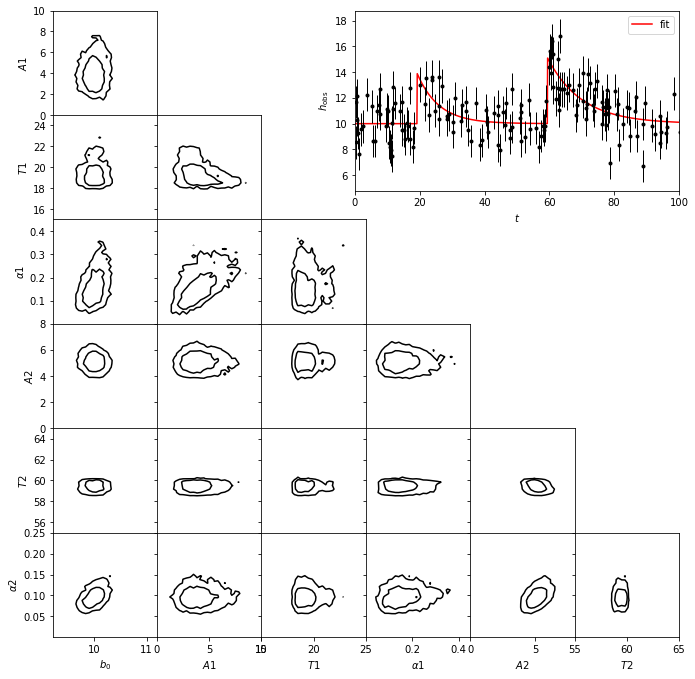

In [56]:
traces = sample_model(two_bursts=True)
plot_traces(traces, two_bursts=True)

In [53]:
def sample_model(two_bursts):
    if two_bursts == False:
        def burst1(t, b0, A, alpha, T):
            """Burst model"""
            mask = (t >= T)
            y = b0 + mask * A * np.exp(-alpha * (t - T))
            return y
        
        with pm.Model():
            b0 = pm.Uniform('b0', 0, 50)
            A = pm.Uniform('A', 0, 50)
            T = pm.Uniform('T', 0, 100)
            log_alpha = pm.Uniform('log_alpha', -10, 10)

            y = pm.Normal('y', mu=burst1(t, b0, A, np.exp(log_alpha), T), sd=sigma_y, observed=y_obs)

            step = pm.Metropolis()
            traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
        
    else:
        def burst2(t, b0, A1, alpha1, T1, A2, alpha2, T2):
            """Burst model"""
            mask1 = (t >= T1)
            mask2 = (t >= T2)
            y = b0 + mask1 * A1 * np.exp(-alpha1 * (t - T1)) + mask2 * A2 * np.exp(-alpha2 * (t-T2))
            return y
        
        with pm.Model():
            b0 = pm.Uniform('b0', 0, 50)
            A1 = pm.Uniform('A1', 0, 50)
            T1 = pm.Uniform('T1', 0, 100)
            log_alpha1 = pm.Uniform('log_alpha1', -10, 10)
            A2 = pm.Uniform('A2', 0, 50)
            T2 = pm.Uniform('T2', 0, 100)
            log_alpha2 = pm.Uniform('log_alpha2', -10, 10)

            y = pm.Normal('y', mu=burst2(t, b0, A1, np.exp(log_alpha1),T1, A2, np.exp(log_alpha2), T2), sd=sigma_y, observed=y_obs)

            step = pm.Metropolis()
            traces = pm.sample(draws=25000, tune=1000, step=step, chains=1)
    return traces
       

In [52]:
def plot_traces(traces, two_bursts):

    if two_bursts == False:
        df = traces_to_pandas(traces, 1000)
        df["alpha"] = np.exp(traces['log_alpha'])
        del df["log_alpha"]

        variables = ['b0', 'A', 'T', 'alpha' ]
        labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
        limits = [(9.2, 11.2), (2, 12), (55, 65), (0.0, 0.25)] 
        #true = [b0_true, A_true, T_true, alpha_true]

        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(bottom=0.1, top=0.95,
                            left=0.1, right=0.95,
                            hspace=0.05, wspace=0.05)

        # This function plots multiple panels with the traces
        plot_mcmc([df[col] for col in variables],
                  labels=labels, limits=limits,
                  fig=fig, bins=30, colors='k')
                  #true_values=true, fig=fig, bins=30, colors='k')

        # Plot the model fit
        ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
        t_fit = np.linspace(0, 100, 1000)
        y_fit = burst1(t_fit, **df.median())
        #y_true = burst1(t_fit, b0_true, A_true, alpha_true, T_true)

        ax.scatter(t, y_obs, s=9, lw=0, c='k')
        #ax.plot(t_fit, y_true, '--', c='blue', label="true")
        ax.plot(t_fit, y_fit, '-r', label="fit")
        ax.legend()
        ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
        ax.set_xlim(0, 100)
        ax.set_xlabel('$t$')
        ax.set_ylabel(r'$h_{\rm obs}$')

        plt.show()
        
    else:
        df = traces_to_pandas(traces, 1000)
        df["alpha1"] = np.exp(traces['log_alpha1'])
        df["alpha2"] = np.exp(traces['log_alpha2'])
        del df["log_alpha1"]
        del df["log_alpha2"]

        variables = ['b0', 'A1', 'T1', 'alpha1', 'A2', 'T2', 'alpha2']
        labels = ['$b_0$', '$A1$', '$T1$', r'$\alpha1$','$A2$', '$T2$', r'$\alpha2$']
        limits = [(9.2, 11.2), (0, 10), (15, 25), (0.001, 0.45),(0, 8), (55, 65), (0.001, 0.25)]
        #true = [b0_true, A_true, T_true, alpha_true]

        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(bottom=0.1, top=0.95,
                            left=0.1, right=0.95,
                            hspace=0.05, wspace=0.05)

        # This function plots multiple panels with the traces
        plot_mcmc([df[col] for col in variables],
                  labels=labels, limits=limits,
                  fig=fig, bins=30, colors='k')
                  #true_values=true, fig=fig, bins=30, colors='k')

        # Plot the model fit
        ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
        t_fit = np.linspace(0, 100, 1000)
        y_fit = burst2(t_fit, **df.median())
        #y_true = burst2(t_fit, b0_true, A_true, alpha_true, T_true)

        ax.scatter(t, y_obs, s=9, lw=0, c='k')
        #ax.plot(t_fit, y_true, '--', c='blue', label="true")
        ax.plot(t_fit, y_fit, '-r', label="fit")
        ax.legend()
        ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
        ax.set_xlim(0, 100)
        ax.set_xlabel('$t$')
        ax.set_ylabel(r'$h_{\rm obs}$')

        plt.show()
